In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
import gensim
from datasets import Dataset
import spacy
import core.model_utils as model_utils
import core.constants as constants
import matplotlib.pyplot as plt
import os

In [ ]:
# Needs to be used to download spacy model for Polish
# !python -m spacy download pl_core_news_sm

In [ ]:
# spacy_model = spacy.load("pl_core_news_sm")
#
# # Stop words
# stop_words = spacy_model.Defaults.stop_words.copy()
# stop_words.remove("nie")
#
# # Punctuation
# punctuations = string.punctuation
#
#
# # Tokenizer
# def spacy_tokenizer(sentence):
#     doc = spacy_model(sentence)
#
#     # Lemmatizing each token and converting each token into lowercase
#     my_tokens = [ word.lemma_.lower().strip() for word in doc ]
#
#     # Removing stop words and punctuation
#     my_tokens = [ word for word in my_tokens if word not in stop_words and word not in punctuations ]
#     return my_tokens
#
#
# df = pd.read_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl.json')
# df = df.drop(columns=['text'])
# df['tokens'] = df['text_pl'].apply(spacy_tokenizer)
# df['joined_tokens'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
# df.to_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens_no_diacritics.json')

In [2]:
tokenized_sentences_df = pd.read_json(
    './../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens_no_diacritics.json')
tokenized_sentences_df

,emotions,text_pl,tokens,joined_tokens
0,anger,Czuje sie calkowicie chciwy,"[czuje, calkowicie, chciwy]",czuje calkowicie chciwy
1,fear,Czuje sie tak przytloczony emocjami,"[czuje, przytloczyć, emocja]",czuje przytloczyć emocja
2,surprise,Nie czulem efektu sily g Jestem oszolomiony Po...,"[nie, czul, efekt, sily, g, oszolomić, poszedl...",nie czul efekt sily g oszolomić poszedl przeja...
3,anger,ive just got to tell you all that I feel Racze...,"[ive, just, got, tell, you, all, that, feel, r...",ive just got tell you all that feel raczej nie...
4,anger,"Powiedzialem ci, ze przepraszam, ze czujesz si...","[powiedzial, przepraszać, czuć, sfrustrować, z...",powiedzial przepraszać czuć sfrustrować zapyta...
...,...,...,...,...
39995,joy,"czuje sie ostatnio dosc hojny, poniewaz pracuj...","[czuć, ostatnio, hojny, pracować, znacznie, wi...",czuć ostatnio hojny pracować znacznie wiecej z...
39996,love,"Czuje, ze niektore postacie nie zasluguja na w...","[czuje, niektory, postać, nie, zaslugujać, wsp...",czuje niektory postać nie zaslugujać wsparcie ...
39997,fear,"Czuje strach w moich kosciach, ktorego nie moz...","[czuć, strach, koscio, nie, wytrzasnac, wymusz...",czuć strach koscio nie wytrzasnac wymuszć racj...
39998,joy,Czulem sie bardziej kreatywny i mniej jak czys...,"[czul, kreatywny, czysty, redaktor]",czul kreatywny czysty redaktor


In [3]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

tokenized_sentences_df = tokenized_sentences_df.replace({"emotions": ordered_class_labels})

In [4]:
full_dataset = Dataset.from_pandas(tokenized_sentences_df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['emotions', 'text_pl', 'tokens', 'joined_tokens'],
    num_rows: 40000
})

In [5]:
# Train set: 80%, Validation set: 10%, Test set: 10%
train_dataset, val_dataset, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [6]:
# Word2Vec
tokenized_sentences = train_dataset['tokens']
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=100, window=6, min_count=1)
w2v_model.train(tokenized_sentences, epochs=10, total_examples=len(tokenized_sentences))

(2558041, 2940330)

In [7]:
def tokens_to_vector(tokens, max_tokens=50):
    vector_size = w2v_model.vector_size
    wv_res = np.zeros((vector_size, max_tokens))
    for index, word in enumerate(tokens):
        if word in w2v_model.wv and index < max_tokens:
            wv_res.T[index] = w2v_model.wv[word]
    return wv_res.T

In [8]:
def tokenize_for_word2vec(sample):
    sample['embeddings'] = [tokens_to_vector(tokens) for tokens in sample['tokens']]
    return sample


train_dataset = train_dataset.map(tokenize_for_word2vec, batched=True)
val_dataset = val_dataset.map(tokenize_for_word2vec, batched=True)
test_dataset = test_dataset.map(tokenize_for_word2vec, batched=True)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [9]:
columns = ["embeddings"]
label_cols = ["emotions"]
batch_size = 16

tf_train_dataset = model_utils.convert_to_tf_dataset(train_dataset, columns, label_cols, None, batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(val_dataset, columns, label_cols, None, batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(test_dataset, columns, label_cols, None, batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

In [11]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [12]:
# Model parameters
training_number = 1
model_name = 'emotions_pl_word2vec_own_no_diacritics'
training_name = f"training_{training_number}"
figures_dir = f"./../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [13]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [14]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=10,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
2000/2000 [==============================] - 14s 7ms/step - loss: 1.6606 - accuracy: 0.2838 - val_loss: 1.5814 - val_accuracy: 0.3363

Epoch 00001: saving model to ./../training_checkpoints\emotions_pl_word2vec_own_no_diacritics\training_1\cp-0001.ckpt
Epoch 2/10
2000/2000 [==============================] - 13s 6ms/step - loss: 1.5250 - accuracy: 0.3581 - val_loss: 1.5363 - val_accuracy: 0.3595

Epoch 00002: saving model to ./../training_checkpoints\emotions_pl_word2vec_own_no_diacritics\training_1\cp-0002.ckpt
Epoch 3/10
2000/2000 [==============================] - 13s 6ms/step - loss: 1.4464 - accuracy: 0.3956 - val_loss: 1.5287 - val_accuracy: 0.3753

Epoch 00003: saving model to ./../training_checkpoints\emotions_pl_word2vec_own_no_diacritics\training_1\cp-0003.ckpt
Epoch 4/10
2000/2000 [==============================] - 13s 7ms/step - loss: 1.3765 - accuracy: 0.4287 - val_loss: 1.5417 - val_accuracy: 0.3765

Epoch 00004: saving model to ./../training_checkpoints\emotion

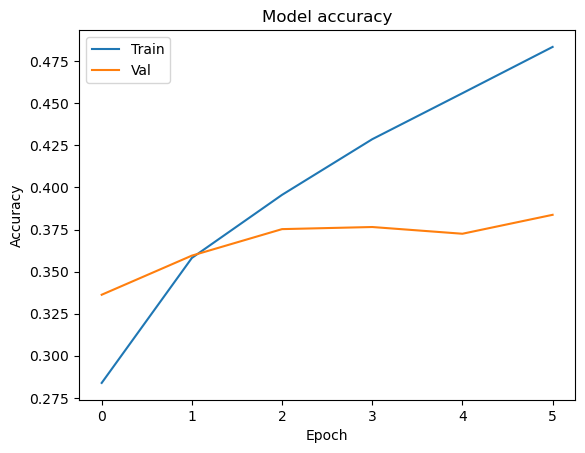

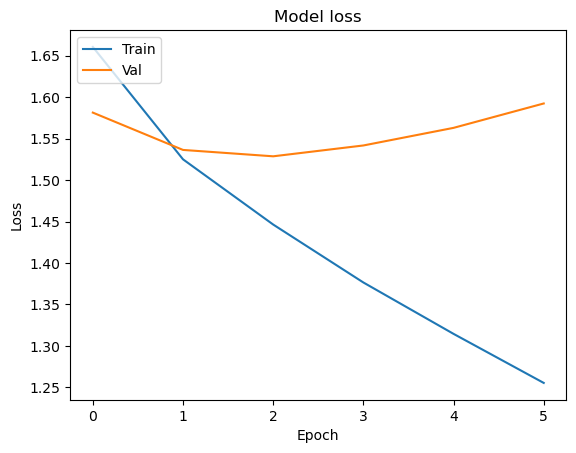

In [15]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [16]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [17]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ./../trained_models\emotions_pl_word2vec_own_no_diacritics_1\1\assets


In [28]:
w2v_model.save(f"./word2vec/{model_name}_{training_number}.model")

In [29]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

250/250 [==============================] - 1s 6ms/step - loss: 1.5180 - accuracy: 0.3660


[1.5179704427719116, 0.3659999966621399]

In [30]:
class_preds = model_utils.get_class_preds(best_model, tf_test_dataset, model_returns_logits=False)

In [31]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['emotions'],
    class_preds=class_preds,
    average='micro'
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.366
Recall score:  0.366
F1 score:  0.366


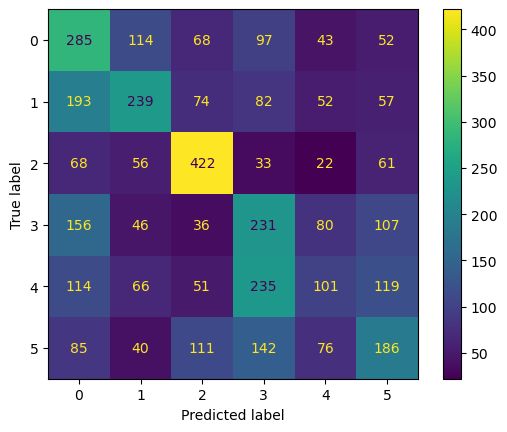

In [32]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [33]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['text_pl'],
                                              class_actual=test_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 2
            - TEXT: Ostatnio czuje sie dosc nostalgicznie, ale to mile uczucie i lubie patrzec wstecz na te wspomnienia
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: Nie sadze, ze wymienilem choc jeden usmiech z nieznajomym na ulicy, ktory wciaz wydaje mi sie dziwny.
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 2
            

            BAD PREDICTION:
            - INDEX: 6
            - TEXT: Nie wiem, jak kilka zdan moze sprawic, ze ludzie, ktorzy je czytaja, natychmiast wiedza, co naprawde mysle lub czuje, a nikt nie zadal sobie trudu, aby zapytac mnie w twarz.
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 7
            - TEXT: Po prostu nienawidze tego, ze sprawilo, ze czuje sie tak paranoicznie i sprawia, ze martwie sie, ze kiedy

In [34]:
test_df = pd.DataFrame(
    list(zip(test_dataset['text_pl'], test_dataset['emotions'], class_preds)),
    columns=['text_pl', 'emotions', 'prediction'])
test_df

,text_pl,emotions,prediction
0,"Mysle, ze to prawdopodobnie dobry pomysl, wcia...",5,5
1,"Wciaz czuje, ze wciaz boje sie tego uczucia i ...",5,5
2,"Ostatnio czuje sie dosc nostalgicznie, ale to ...",1,2
3,"Jestem pod wrazeniem, ze udalo mi sie wyciagna...",2,2
4,"Nie sadze, ze wymienilem choc jeden usmiech z ...",2,1
...,...,...,...
3995,Czuje sie wspaniale zrelaksowany w wyniku,0,0
3996,Czuje sie zrzedliwy teraz fani futbolu obudzil...,4,3
3997,"sa zwiazani z tym, co robia, pomimo tego, jak ...",0,0
3998,"Czuje i bedziesz zaskoczony zmianami, ktore na...",2,2


In [35]:
def map_token_counts(row):
    return len(row['text_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['emotions'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text_pl,emotions,prediction,token_count,count_belonging,correctly_predicted
0,"Mysle, ze to prawdopodobnie dobry pomysl, wcia...",5,5,13,12-17,1
1,"Wciaz czuje, ze wciaz boje sie tego uczucia i ...",5,5,21,18-23,1
2,"Ostatnio czuje sie dosc nostalgicznie, ale to ...",1,2,16,12-17,0
3,"Jestem pod wrazeniem, ze udalo mi sie wyciagna...",2,2,11,6-11,1
4,"Nie sadze, ze wymienilem choc jeden usmiech z ...",2,1,17,12-17,0
...,...,...,...,...,...,...
3995,Czuje sie wspaniale zrelaksowany w wyniku,0,0,6,6-11,1
3996,Czuje sie zrzedliwy teraz fani futbolu obudzil...,4,3,12,12-17,0
3997,"sa zwiazani z tym, co robia, pomimo tego, jak ...",0,0,22,18-23,1
3998,"Czuje i bedziesz zaskoczony zmianami, ktore na...",2,2,9,6-11,1


In [36]:
test_df = test_df.drop(test_df[test_df.token_count > 41].index)

In [37]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

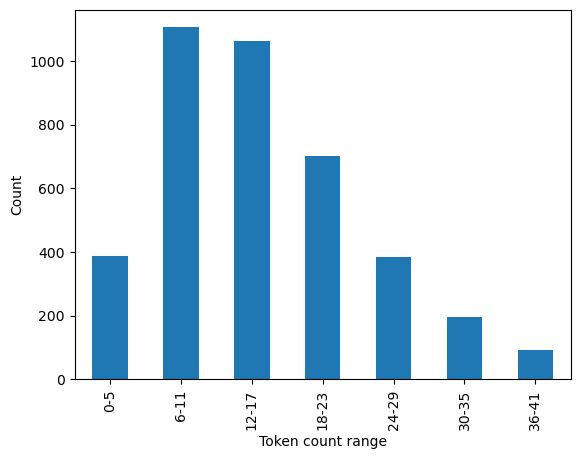

In [38]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [39]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0., '30-35': 0., '36-41': 0.}

In [40]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 173, '6-11': 447, '12-17': 394, '18-23': 248, '24-29': 116, '30-35': 45, '36-41': 24}
Element count:  {'0-5': 386, '6-11': 1106, '12-17': 1064, '18-23': 702, '24-29': 383, '30-35': 197, '36-41': 93}
Accuracies:  {'0-5': 0.4481865284974093, '6-11': 0.40415913200723325, '12-17': 0.37030075187969924, '18-23': 0.35327635327635326, '24-29': 0.3028720626631854, '30-35': 0.22842639593908629, '36-41': 0.25806451612903225}


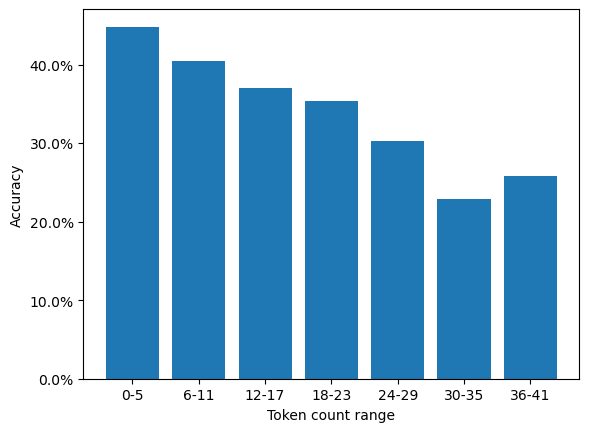

In [41]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29', '30-35', '36-41'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()